In [1678]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.weightstats import ttest_ind
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from itertools import combinations
import pprint
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Plot styles
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['patch.edgecolor'] = '#ffffff'
plt.rcParams['patch.facecolor'] = '#ffffff'
plt.rcParams['savefig.edgecolor'] = '#ffffff'
plt.rcParams['savefig.facecolor'] = '#ffffff'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Make multiple prints work
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#pd.show_versions(as_json=False)

In [1679]:
# 1.1. Load dataset
cs = pd.read_json('../step3/coins-20150705-20180701-filtered.json')
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10607 entries, 0 to 10606
Data columns (total 8 columns):
24hr_volume           10607 non-null object
circulating_supply    10607 non-null object
date                  10607 non-null int64
market_cap            10607 non-null object
name                  10607 non-null object
price                 10607 non-null float64
rank                  10607 non-null int64
symbol                10607 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 663.0+ KB


In [1680]:
# 1.2. Cleaning

# Drop unneeded columns
cs.drop(['24hr_volume', 'market_cap','rank',], inplace=True, axis=1)
cs.info()
print()

# Convert date type from int64 to timestamp (plotting benefits)
cs['date'] = pd.to_datetime(cs['date'], format='%Y%m%d')

# Replace all '?' with NaN (conforming to Pandas standard for missing data)
cs.replace('?', np.nan, inplace=True)

# Check for empty cells
cs.info()
print()

# Remove all rows, containing at least one NaN
cs.dropna(inplace=True)

# Final dataset
cs.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10607 entries, 0 to 10606
Data columns (total 5 columns):
circulating_supply    10607 non-null object
date                  10607 non-null int64
name                  10607 non-null object
price                 10607 non-null float64
symbol                10607 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 414.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10607 entries, 0 to 10606
Data columns (total 5 columns):
circulating_supply    10060 non-null float64
date                  10607 non-null datetime64[ns]
name                  10607 non-null object
price                 10607 non-null float64
symbol                10607 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 414.4+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10060 entries, 0 to 10604
Data columns (total 5 columns):
circulating_supply    10060 non-null float64
date                  10060 non-null datet

In [1681]:
# 1.3. Check for one-to-one relationship between {symbol} <-> {name}
cs['symbol'].nunique()
cs['name'].nunique()

g = cs[['symbol', 'name']].groupby(['symbol', 'name']).size().reset_index()
mask = g.groupby('symbol')['name'].transform('size') > 1
g[mask].rename(columns={0: "count"})

149

166

,symbol,name,count
8,bat,basic attenti...,57
9,bat,batcoin,53
16,blz,blazecoin,82
17,blz,bluzelle,21
19,bnt,bancor,53
20,bnt,bantam,50
24,btg,bitcoin gold,32
25,btg,bitgem,63
26,btm,bitmark,157
27,btm,bytom,47


In [1682]:
# 1.4 Investigate the reasons why that is (qualitative analysis in Google Drive - table)

In [1683]:
# 1.5 Drop the irrelevant cryptocurrency instances
cs.drop(cs[cs['name'] == 'batcoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'blazecoin'].index, inplace=True)
cs['name'].replace('bnb coin', 'binance coin', inplace=True)
cs.drop(cs[cs['name'] == 'bantam'].index, inplace=True)
cs.drop(cs[cs['name'] == 'bitgem'].index, inplace=True)
cs.drop(cs[cs['name'] == 'bitmark'].index, inplace=True)
cs.drop(cs[cs['name'] == 'comet'].index, inplace=True)
cs.drop(cs[cs['name'] == 'faucetcoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'ethercoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'global tour coin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'hydro protocol'].index, inplace=True)
cs.drop(cs[cs['name'] == 'icoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'icon [futures]'].index, inplace=True)
cs.drop(cs[cs['name'] == 'khancoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'kingn coin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'nas'].index, inplace=True)
cs.drop(cs[cs['name'] == 'polybit'].index, inplace=True)
cs.drop(cs[cs['name'] == 'smartbillions'].index, inplace=True)
cs.drop(cs[cs['name'] == 'subcriptio'].index, inplace=True)
cs.drop(cs[cs['name'] == 'icoin'].index, inplace=True)
cs.drop(cs[cs['name'] == 'infinity econ...'].index, inplace=True)
cs['name'].replace('ripple', 'xrp', inplace=True)

# If one-to-one relationship is established, the outputs should match
cs['symbol'].nunique()
cs['name'].nunique()

# If one-to-one relationship is established, the output should be an empty table
g = cs[['symbol', 'name']].groupby(['symbol', 'name']).size().reset_index()
mask = g.groupby('symbol')['name'].transform('size') > 1
g[mask]

149

149

,symbol,name,0


In [1684]:
# 1.6 Identify cryptocurrencies with less than 12 instances
g = cs[['symbol', 'name']].groupby(['symbol', 'name']).size().reset_index().rename(columns={0: "count"})
g[g['count'] < 12]

# Drop them from the dataset
for name in g[g['count'] < 12]['name'].values:
    cs.drop(cs[cs['name'] == name].index, inplace=True)

# If properly cleaned, the output should be an empty table
g = cs[['symbol', 'name']].groupby(['symbol', 'name']).size().reset_index().rename(columns={0: "count"})
g[g['count'] < 12]

,symbol,name,count
12,bft,bnktothefuture,9
27,ctxc,cortex,11
29,cvt,cybervein,10
61,hot,holo,8
64,ht,huobi token,10
85,moac,moac,5
87,mtc,docademic,8
93,nexo,nexo,8
97,ode,odem,10
127,tpay,tokenpay,11


,symbol,name,count


In [1685]:
# 1.7 Change the dataframe in a more convenient format {symbol, date} -> {price}

# Calculate the market cap of coins in 'cs'
# subset = cs[cs['date'] == '2018-06-24']
# (subset['circulating_supply'] * subset['price']).sum()

cs = cs.groupby(['symbol', 'date']).first().drop('name', axis=1)

In [1686]:
# 1.10 List of coins by market cap as of 07.2018
# Remove 'xtz' (placed before 'omg') as did not conform to some 
top150 = ["btc","eth","xrp","bch","eos","ltc","xlm","ada","miota","usdt","neo","trx","xmr","dash","etc","xem","bnb","ven","omg","qtum","zec","ont","icx","zil","lsk","bcn","zrx","dcr","ae","btg","bts","steem","rep","btm","sc","xvg","nano","mkr","dgb","gnt","bcd","doge","ppt","waves","snt","rhoc","strat","wan","hsr","bat","kcs","wtc","btcp","xin","iost","nas","dgd","lrc","ht","aion","mith","kmd","gxs","elf","ardr","ark","bnt","maid","loom","fun","mona","ethos","mco","gas","rdd","dcn","knc","cnx","veri","emc","cmt","pivx","ctxc","ela","poly","drop","eng","mana","kin","moac","powr","theta","etn","qash","nxt","bix","dent","wicc","wax","smart","sys","payx","gto","storm","tusd","sub","fct","nuls","cennz","ddd","xzc","man","gtc","zen","nxs","link","fsn","mtc","gbyte","salt","block","storj","drgn","cvc","icn","pay","tpay","agi","btcd","dbc","act","blz","nexo","hpb","hot","mds","rlc","r","ode","tnb","bft","ncash","sky","gno","ant","cvt","grs","req","nebl"]

In [1687]:
# 2. Load market cap datasets
mc = pd.read_json('../step3/mc-20150705-20180701-with-btc.json')
'All columns: ' + ', '.join(mc.columns.tolist())

'All columns: date, value'

In [1688]:
# 2.1 Convert date type from int64 to timestamp (plotting benefits)
mc['date'] = pd.to_datetime(mc['date'], format='%Y%m%d')

In [1689]:
# 2.2 Check for empty data
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 2 columns):
date     1093 non-null datetime64[ns]
value    1093 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.2 KB


In [1690]:
# 2.3 Set index
mc.set_index('date', inplace=True)

# Check for duplicates
mc[mc.index.duplicated()]

# Leave only the first record of duplicate rows (same index)
mc = mc[~mc.index.duplicated(keep='first')]

# Should procude empty table
mc[mc.index.duplicated()]

mc.rename(columns={'value': 'total_market_cap'}, inplace=True)

mc.loc['2018-06-24']

,value
date,
2015-10-25,4723990000
2016-10-30,13528300000
2017-10-29,178886000000
2018-06-30,254507000000


,value
date,


total_market_cap    259487000000
Name: 2018-06-24 00:00:00, dtype: int64

In [1691]:
# 2.4 (TODO in the stationarity section) Add column to store the result of Total Market Cap and Circulating Supply * Price (prevent double-counting)
# Makes correlations more accurate (
cs['total_mc_minus_coin'] = np.nan

for symb in cs.index.get_level_values(0).unique():
    c = cs.loc[symb]
    temp = c.join(mc['total_market_cap'], how='left')
    c['total_mc_minus_coin'] = temp['total_market_cap'] - (temp['circulating_supply'] * temp['price'])

#coinsToTotalMCCorr['delta'] = np.absolute(coinsToTotalMCCorr['pearson'] - coinsToTotalMCCorr['spearman'])
#coinsToTotalMCCorr[coinsToTotalMCCorr['delta'] > 0.2]

In [1692]:
# 3. Load indices datasets
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# # Load DJIA
# dj = pd.read_csv('../step3/DJIA.csv', 
#                  header=0,
#                  names=['date', 'djia'],
#                  parse_dates=['date'], 
#                  date_parser=dateparse, 
#                  na_values=['.'])

# # Load SP500
# sp = pd.read_csv('../step3/SP500.csv', 
#                  header=0,
#                  names=['date', 'sp500'],
#                  parse_dates=['date'], 
#                  date_parser=dateparse, 
#                  na_values=['.'])

# # Load NASDAQCOM
# ns = pd.read_csv('../step3/NASDAQCOM.csv', 
#                  header=0,
#                  names=['date', 'nasdaqcom'],
#                  parse_dates=['date'], 
#                  date_parser=dateparse, 
#                  na_values=['.'])

# # Check DJIA for empty data
# 'DJIA: ' + str(dj.shape[0])
# dj.count()
# dj['date'].nunique()

# # Check SP500 for empty data
# 'SP500: ' + str(sp.shape[0])
# sp.count()
# sp['date'].nunique()

# # Check NASDAQCOM for empty data
# 'NASDAQCOM: ' + str(ns.shape[0])
# ns.count()
# ns['date'].nunique()

# # Merge indices in one data frame
# inds = dj.merge(sp, how='inner', on='date').merge(ns, how='inner', on='date')
# inds.set_index('date', inplace=True)
# inds

In [1693]:
# MODELING
# Perform Dickey-Fuller test

def get_adf(ts):
    
    if not isinstance(ts, pd.Series):
        raise Exception('ts is not a pd.Series!')
    
    if ts.count() == 0:
        test = [np.nan, np.nan, np.nan, np.nan, {'1%': np.nan, '5%': np.nan, '10%': np.nan}]
    else:
        test = adfuller(ts.dropna(), autolag='AIC')
    # END ISSUE
    
    return {
        'adf': test[0],
        'p_value': test[1],
        'lags_used': test[2],
        'num_obs_used': test[3],
        'crit_value_1': test[4]['1%'],
        'crit_value_5': test[4]['5%'],
        'crit_value_10': test[4]['10%']
    }

def get_kpss(ts):
    
    if not isinstance(ts, pd.Series):
        raise Exception('ts is not a pd.Series!')
    
    if ts.count() == 0:
        test = [np.nan, np.nan, np.nan, {'1%': np.nan, '5%': np.nan, '10%': np.nan}]
    else:
        test = kpss(ts.dropna())
        
    return {
        'kpss': test[0],
        'p_value': test[1],
        'lags_used': test[2],
        'crit_value_1': test[3]['1%'],
        'crit_value_5': test[3]['5%'],
        'crit_value_10': test[3]['10%']
    }

def run_tests(cs, colName):
    
    symbToAdf = {symb:get_adf(cs.loc[symb][colName]) for symb in cs.index.get_level_values(0).unique()}
    symbToKpss = {symb:get_kpss(cs.loc[symb][colName]) for symb in cs.index.get_level_values(0).unique()}
    
    csToAdf = pd.DataFrame.from_dict(symbToAdf, orient='index')
    csToKpss = pd.DataFrame.from_dict(symbToKpss, orient='index')
    
    maskDoneAdf = csToAdf['adf'] <= csToAdf['crit_value_5']
    maskDoneKpss = csToKpss['kpss'] >= 0.5
    
    # Get the coins which pass both ADF and KPSS
    symbsAdfDone = set(csToAdf[maskDoneAdf].index.values)
    symbsKpssDone = set(csToKpss[maskDoneKpss].index.values)
    
    #symbsAdfKpssDone = symbsAdfDone.intersection(symbsKpssDone)
    symbsAdfKpssDone = symbsAdfDone
    
    symbsAdfKpssTodo = set(cs.index.get_level_values(0).unique()) - symbsAdfKpssDone
    
    # Divide the stationary and non-stationary into 2 sets
    stationaryDF = cs.loc[list(symbsAdfKpssDone)].copy()
    nonStationaryDF = cs.loc[list(symbsAdfKpssTodo)].copy()
    
    return stationaryDF, nonStationaryDF

def is_mc_stationary(mc, colName):
    mcAdf = get_adf(mc[colName])
    mcKpss = get_kpss(mc[colName])
    return (mcAdf['adf'] <= mcAdf['crit_value_5'])

# 1) Raw data

csRaw, csSub = run_tests(cs, 'price')
print('1) Test results (stationary/non-stationary):', csRaw.groupby(level=0).size().count(), '/', csSub.groupby(level=0).size().count())
print('1) Test results MC:', 'stationary' if is_mc_stationary(mc, 'total_market_cap') else 'non-stationary')

# 2) Log

csSub['price_log'] = np.log(csSub['price'])
csLog, csSub = run_tests(csSub, 'price_log')
print('2) Test results (stationary/non-stationary):', csLog.groupby(level=0).size().count(), '/', csSub.groupby(level=0).size().count())

mc['log'] = np.log(mc['total_market_cap'])
print('2) Test results MC:', 'stationary' if is_mc_stationary(mc, 'log') else 'non-stationary')

# 3) Log diff

csSub['price_log_diff'] = np.nan
for symb in csSub.index.get_level_values(0).unique():
    c = csSub.loc[symb]
    c['price_log_diff'] = c['price_log'] - c['price_log'].shift()

csLogDiff, csSub = run_tests(csSub, 'price_log_diff')
print('3) Test results (stationary/non-stationary):', csLogDiff.groupby(level=0).size().count(), '/', csSub.groupby(level=0).size().count())

mc['log_diff'] = mc['log'] - mc['log'].shift()
print('3) Test results MC:', 'stationary' if is_mc_stationary(mc, 'log_diff') else 'non-stationary')

# 4) Log diff 2

csSub['price_log_diff2'] = np.nan
for symb in csSub.index.get_level_values(0).unique():
    c = csSub.loc[symb]
    c['price_log_diff2'] = c['price_log_diff'] - c['price_log_diff'].shift()
    
csLogDiff2, csSub = run_tests(csSub, 'price_log_diff2')
print('4) Test results (stationary/non-stationary):', csLogDiff2.groupby(level=0).size().count(), '/', csSub.groupby(level=0).size().count())

# 5) Log diff 3

csSub['price_log_diff3'] = np.nan
for symb in csSub.index.get_level_values(0).unique():
    c = csSub.loc[symb]
    c['price_log_diff3'] = c['price_log_diff2'] - c['price_log_diff2'].shift()

csLogDiff3, csSub = run_tests(csSub, 'price_log_diff3')
print('5) Test results (stationary/non-stationary):', csLogDiff3.groupby(level=0).size().count(), '/', csSub.groupby(level=0).size().count())


1) Test results (stationary/non-stationary): 22 / 115
1) Test results MC: non-stationary
2) Test results (stationary/non-stationary): 13 / 102
2) Test results MC: non-stationary
3) Test results (stationary/non-stationary): 75 / 27
3) Test results MC: stationary
4) Test results (stationary/non-stationary): 10 / 17
5) Test results (stationary/non-stationary): 2 / 15


In [1694]:
# Analyse the last coins which remained non-stationary
csSub.index.get_level_values(0).unique()

Index(['agi', 'bcd', 'blz', 'cennz', 'ela', 'fsn', 'loom', 'man', 'mith',
       'ncash', 'ont', 'poly', 'theta', 'wan', 'zil'],
      dtype='object', name='symbol')

In [1695]:
# Correlations
df = pd.DataFrame(
    index=cs.index.get_level_values(0).unique(),
    columns=cs.index.get_level_values(0).unique(), 
    dtype=float)

t_df = pd.DataFrame(
    index=cs.index.get_level_values(0).unique(),
    columns=cs.index.get_level_values(0).unique(), 
    dtype=float)

# Insert row and column for total market cap
df['total_mc'] = np.nan
df.loc["total_mc"] = np.nan
t_df['total_mc'] = np.nan
t_df.loc["total_mc"] = np.nan

# ORDER:
# csRaw
# csLog
# csLogDiff
# csLogDiff2
# csLogDiff3

def calcCorr(symb, c, cs, corrdf, colName):
    for symbY in cs.index.get_level_values(0).unique():
        corr = c.corr(cs.loc[symbY][colName]).round(2)
        corrdf.at[symb, symbY] = corr
        corrdf.at[symbY, symb] = corr
        
        res = ttest_ind(c.dropna(), cs.loc[symbY][colName].dropna())
        t_df.at[symb, symbY] = res[1]
        t_df.at[symbY, symb] = res[1]

def calcCorrMC(symb, c, corrdf):
    corr = c.corr(mc['log_diff']).round(2)
    corrdf.at[symb, 'total_mc'] = corr
    corrdf.at['total_mc', symb] = corr
    
    res = ttest_ind(c.dropna(), mc['log_diff'].dropna())
    t_df.at[symb, 'total_mc'] = res[1]
    t_df.at['total_mc', symb] = res[1]

# csRaw with all others
for symb in csRaw.index.get_level_values(0).unique():
    c = csRaw.loc[symb]['price']
    calcCorr(symb, c, csRaw, df, 'price')
    calcCorr(symb, c, csLog, df, 'price_log')
    calcCorr(symb, c, csLogDiff, df, 'price_log_diff')
    calcCorr(symb, c, csLogDiff2, df, 'price_log_diff2')
    calcCorr(symb, c, csLogDiff3, df, 'price_log_diff3')
    calcCorrMC(symb, c, df)    

# csLog with all others
for symb in csLog.index.get_level_values(0).unique():
    c = csLog.loc[symb]['price_log']
    calcCorr(symb, c, csLog, df, 'price_log')
    calcCorr(symb, c, csLogDiff, df, 'price_log_diff')
    calcCorr(symb, c, csLogDiff2, df, 'price_log_diff2')
    calcCorr(symb, c, csLogDiff3, df, 'price_log_diff3')
    calcCorrMC(symb, c, df)

# csLogDiff with all others
for symb in csLogDiff.index.get_level_values(0).unique():
    c = csLogDiff.loc[symb]['price_log_diff']
    calcCorr(symb, c, csLogDiff, df, 'price_log_diff')
    calcCorr(symb, c, csLogDiff2, df, 'price_log_diff2')
    calcCorr(symb, c, csLogDiff3, df, 'price_log_diff3')
    calcCorrMC(symb, c, df)

# csLogDiff2 with all others
for symb in csLogDiff2.index.get_level_values(0).unique():
    c = csLogDiff2.loc[symb]['price_log_diff2']
    calcCorr(symb, c, csLogDiff2, df, 'price_log_diff2')
    calcCorr(symb, c, csLogDiff3, df, 'price_log_diff3')
    calcCorrMC(symb, c, df)

# csLogDiff3 with all others
for symb in csLogDiff3.index.get_level_values(0).unique():
    c = csLogDiff3.loc[symb]['price_log_diff3']
    calcCorr(symb, c, csLogDiff3, df, 'price_log_diff3')
    calcCorrMC(symb, c, df)

df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
t_df.dropna(axis=0, how='all', inplace=True)
t_df.dropna(axis=1, how='all', inplace=True)

t_df = t_df.round(2)

# t_df[t_df <= 0.05].isna().sum()
# t_df.loc['total_mc']

In [1696]:
# LEGACY STUFF
# Transform by decomposition
# csSub['decomp_resid'] = np.nan
# csSub['log_decomp_diff'] = np.nan
# # Transform by removing a standard moving average
# csSub['roll_mean'] = np.nan
# csSub['log_roll_diff'] = np.nan
# # Transform by removing a weighted moving average
# csSub['roll_weighted_mean'] = np.nan
# csSub['log_roll_weighted_diff'] = np.nan

# # Smoothing
# symbs = []

# adfPriceLog = []
# adfPriceLogDiff = []
# adfPriceLogDiff2 = []
# adfPriceLogDiff3 = []
# adfLogDecompDiff = []
# adfLogRollDiff = []
# adfLogEWMDiff = []

# kpssPriceLogDiff2 = []

# # 2) Ln data + test
# #for symb in csSub.index.get_level_values('symbol').unique():

# for symb in csSub.index.get_level_values('symbol').unique():
    
#     numObs = csSub.loc[symb].shape[0]
#     window = int(np.ceil(numObs*0.0764))
#     window = window if window >= 2 else 2
    
#     df = csSub.loc[symb]
    
#     df['price_log_diff'] = df['price_log'] - df['price_log'].shift()
#     df['price_log_diff2'] = df['price_log_diff'] - df['price_log_diff'].shift()
#     df['price_log_diff3'] = df['price_log_diff2'] - df['price_log_diff2'].shift()
    
#     ts = df['price_log'].resample('W').mean().interpolate(method='nearest')
#     df['log_decomp_diff'] = df['price_log'] - seasonal_decompose(ts, freq=window).resid
    
#     df['roll_mean'] = df['price_log'].rolling(window).mean()
#     df['log_roll_diff'] = df['price_log'] - df['roll_mean']
    
#     df['roll_weighted_mean'] = df['price_log'].ewm(halflife=window).mean()
#     df['log_roll_weighted_diff'] = df['price_log'] - df['roll_weighted_mean']
    
#     symbs.append(symb)
    
#     adfPriceLog.append(get_dickey_fuller_stats_of(df['price_log'].dropna()))
#     adfPriceLogDiff.append(get_dickey_fuller_stats_of(df['price_log_diff'].dropna()))
#     adfPriceLogDiff2.append(get_dickey_fuller_stats_of(df['price_log_diff2'].dropna()))
#     adfPriceLogDiff3.append(get_dickey_fuller_stats_of(df['price_log_diff3'].dropna()))
#     adfLogDecompDiff.append(get_dickey_fuller_stats_of(df['log_decomp_diff'].dropna()))
#     adfLogRollDiff.append(get_dickey_fuller_stats_of(df['log_roll_diff'].dropna()))
#     adfLogEWMDiff.append(get_dickey_fuller_stats_of(df['log_roll_weighted_diff'].dropna()))
    
#     kpssPriceLogDiff2.append(get_kpss_stats_of(df['price_log_diff2'].dropna()))

# # Plot
# # csSub.loc['btc'][['price_log', 'roll_mean', 'log_roll_diff', 'roll_weighted_mean', 'log_roll_weighted_diff']].plot()

# csToStats = pd.DataFrame(data=adfPriceLog, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfPriceLogDiff, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfPriceLogDiff2, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfPriceLogDiff3, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfLogDecompDiff, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfLogRollDiff, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=adfLogEWMDiff, index=symbs).round(2)
# csToStats[csToStats['adf'] > csToStats['crit_value_5']].shape

# csToStats = pd.DataFrame(data=kpssPriceLogDiff2, index=symbs).round(3)
# csToStats[csToStats['kpss'] > csToStats['crit_value_5']].shape
# csToStats[csToStats['kpss'] > csToStats['crit_value_5']]
# csToStats[csToStats['p_value'] < 0.05]

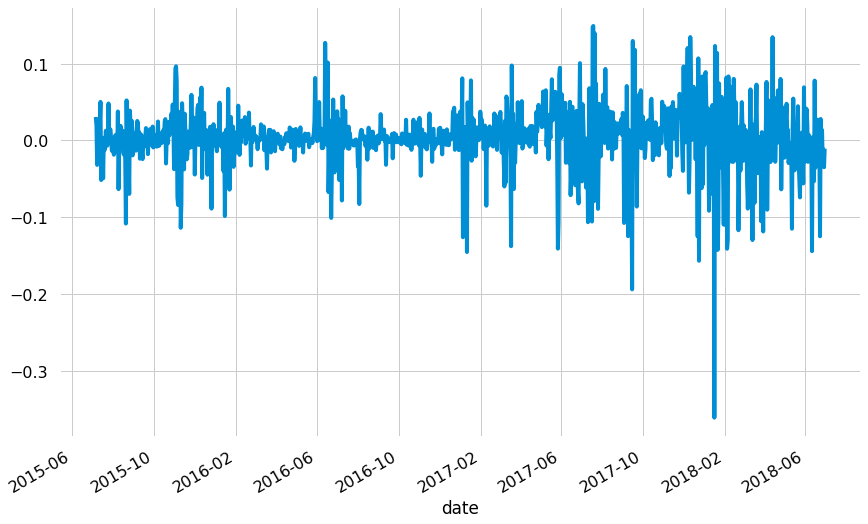

In [1697]:
# Generate graphs before and after the transformations
mc['log_diff'].plot(kind='line')

In [1698]:
# df = df.dropna(axis=(0, 1), how='all')

# # RQ1: What are the coins that are strongly correlated to the overall market?
# # RQ2: What are the coins that are the least correlated to the overall market?

# # Get only the relevant serie for this section
# toMc = df['total_mc'].dropna()

# # Filter out the coins that do NOT fall into the alpha = 0.05 interval
# significantSymbs = t_df.loc['total_mc'][t_df.loc['total_mc'] <= 0.05].index.tolist()
# toMc = toMc[significantSymbs]

# # Descriptive stats
# toMc.describe()

# # Correlated
# toMc[(toMc < -0.2) | (toMc > 0.2)].sort_values(ascending=False)
# totalPos = toMc[(toMc < -0.2) | (toMc > 0.2)].count()

# print('Total strongly correlated (both positive & negative):', totalPos)
# print('Strongly correlated to total cryptocurrency (%)', totalPos / toMc.count())
# print('Total strongly negatively correlated:', toMc[(toMc < -0.2)].count())
# print('Total strongly positively correlated:', toMc[(toMc > 0.2)].count())

# # Uncorrelated
# toMc[(toMc > -0.2) & (toMc < 0.2)].sort_values(ascending=False)
# totalNonCorr = toMc[(toMc >= -0.2) & (toMc <= 0.2)].count()

# print('Total uncorrelated:', totalNonCorr)

# # Generate distplot
# ax = sns.distplot(toMc, hist=True, kde=True, bins=10, color = '#0c2577',
#                   hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})

# #plt.title('Density plot of the correlations between the Total Market Capitalization and cryptocurrencies')
# ax.set(xlabel='Pearson Correlation Coefficient', ylabel='Density')

In [1699]:
# # RQ3: What are the coins that are strongly correlated to Bitcoin?
# # RQ4: What are the coins that are the least correlated to Bitcoin?

# toBTC = df['btc'].dropna()

# # Filter out the coins that do NOT fall into the alpha = 0.05 interval
# significantSymbs = t_df.loc['btc'][t_df.loc['btc'] <= 0.05].index.tolist()
# toBTC = toBTC[significantSymbs]

# # Descriptive stats
# toBTC.describe()

# # Correlated
# toBTC[(toBTC < -0.2) | (toBTC > 0.2)].sort_values(ascending=False)
# totalCorrelated = toBTC[(toBTC < -0.2) | (toBTC > 0.2)].count()

# print('Total strongly correlated (both positive & negative):', totalCorrelated)
# print('Total strongly negatively correlated:', toBTC[(toBTC < -0.2)].count())
# print('Total strongly positively correlated:', toBTC[(toBTC > 0.2)].count())

# # Uncorrelated
# toBTC[(toBTC >= -0.2) & (toBTC <= 0.2)].sort_values(ascending=False)
# totalUncorr = toBTC[(toBTC >= -0.2) & (toBTC <= 0.2)].count()

# print('Total uncorrelated:', totalUncorr)

# # Generate distplot
# ax = sns.distplot(toBTC, hist=True, kde=True, 
#              bins=10, color = '#0c2577', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

# # plt.title('Density plot of the correlation between Bitcoin and the other coins')
# ax.set(xlabel='Pearson Correlation Coefficient', ylabel='Density')

In [1700]:
# # RQ5: How do the top 20 coins by market cap correlate with each other?
top20 = top150[:21]
top20.remove('usdt')

topXCorr = df.loc[top20, top20]

# Filter out the coins that do NOT fall into the alpha = 0.05 interval
topXCorrT = t_df.loc[top20, top20]

for index, row in topXCorr.iterrows():
    for colName in row.index:
        if index == colName:
            continue
        elif topXCorrT.loc[index, colName] > 0.05:
            topXCorr.loc[index, colName] = np.nan

# fig, ax = plt.subplots(1, 1, figsize = (15, 15), dpi=300)

# ax = sns.heatmap(topXCorr,
#                  vmin=-1, vmax=1, center=0,
#                  square=True, annot=True, annot_kws={"size": 12}, fmt=".2f",
#                  cbar_kws={"shrink": 0.5},
#                  linewidths=.5, ax=ax)

# # Lower the size of the tick labels
# ax.tick_params(labelsize=12)

# # Hide labels
# ax.set_ylabel('')
# ax.set_xlabel('')

# # Move x-axis ticks on top
# ax.xaxis.set_ticks_position('top')

def generate_diversified_portfolios(df, group_size):
    portfolios = []
    
    for index, row in df.iterrows():
        
        row.drop(index, inplace=True)
        
        coinToOthersCorr = dict(zip(row.index.tolist(), row.tolist()))
        
        for comb in list(combinations(coinToOthersCorr.items(), 3)):
            score = sum(abs(e[1]) for e in comb)
            other = [e[0] for e in comb]
            score += abs(df.loc[other[0], other[1]]) + abs(df.loc[other[0], other[2]])
            score += abs(df.loc[other[1], other[2]])
            portfolios.append({'coin': index, 'other': comb, 'score': score.round(2)})
            # print(df.loc[[index] + other, [index] + other])
    
    portfolios = [portfolio for portfolio in portfolios if ~np.isnan(portfolio['score'])]
    portfolios.sort(key=lambda i: i['score'])
    print(len(portfolios))
    pp.pprint(portfolios[:30])
    
#     print(df.loc[['bch', 'xlm', 'neo', 'zec'], ['bch', 'xlm', 'neo', 'zec']])
#     print(df.loc[['bch', 'eos', 'miota', 'zec'], ['bch', 'eos', 'miota', 'zec']])
#     print(df.loc[['bch', 'xrp', 'neo', 'zec'], ['bch', 'xrp', 'neo', 'zec']])
#     print(df.loc[['eos', 'miota', 'etc', 'zec'], ['eos', 'miota', 'etc', 'zec']])
        
#         portfolio = []
#         for i in indices_smallest[:group_size]:
#             portfolio.append((row.index[i], row[i]))
        
#         score = reduce(lambda total, x: total + abs(x[1]), portfolio, 0)
#         portfolios.append({index: portfolio, 'score': round(score, 2)})
    
#     return portfolios

# Print a table of top 20

# generate_diversified_portfolios(topXCorr, 3)

# Sort
#portfolios.sort(key=lambda x: x['score'], reverse=False)

# Get the best 30% portfolios of all
#k_best = round(0.3 * len(portfolios))

# Show portfolios
# portfolios[:k_best]




Generating image for # number of nodes: 20


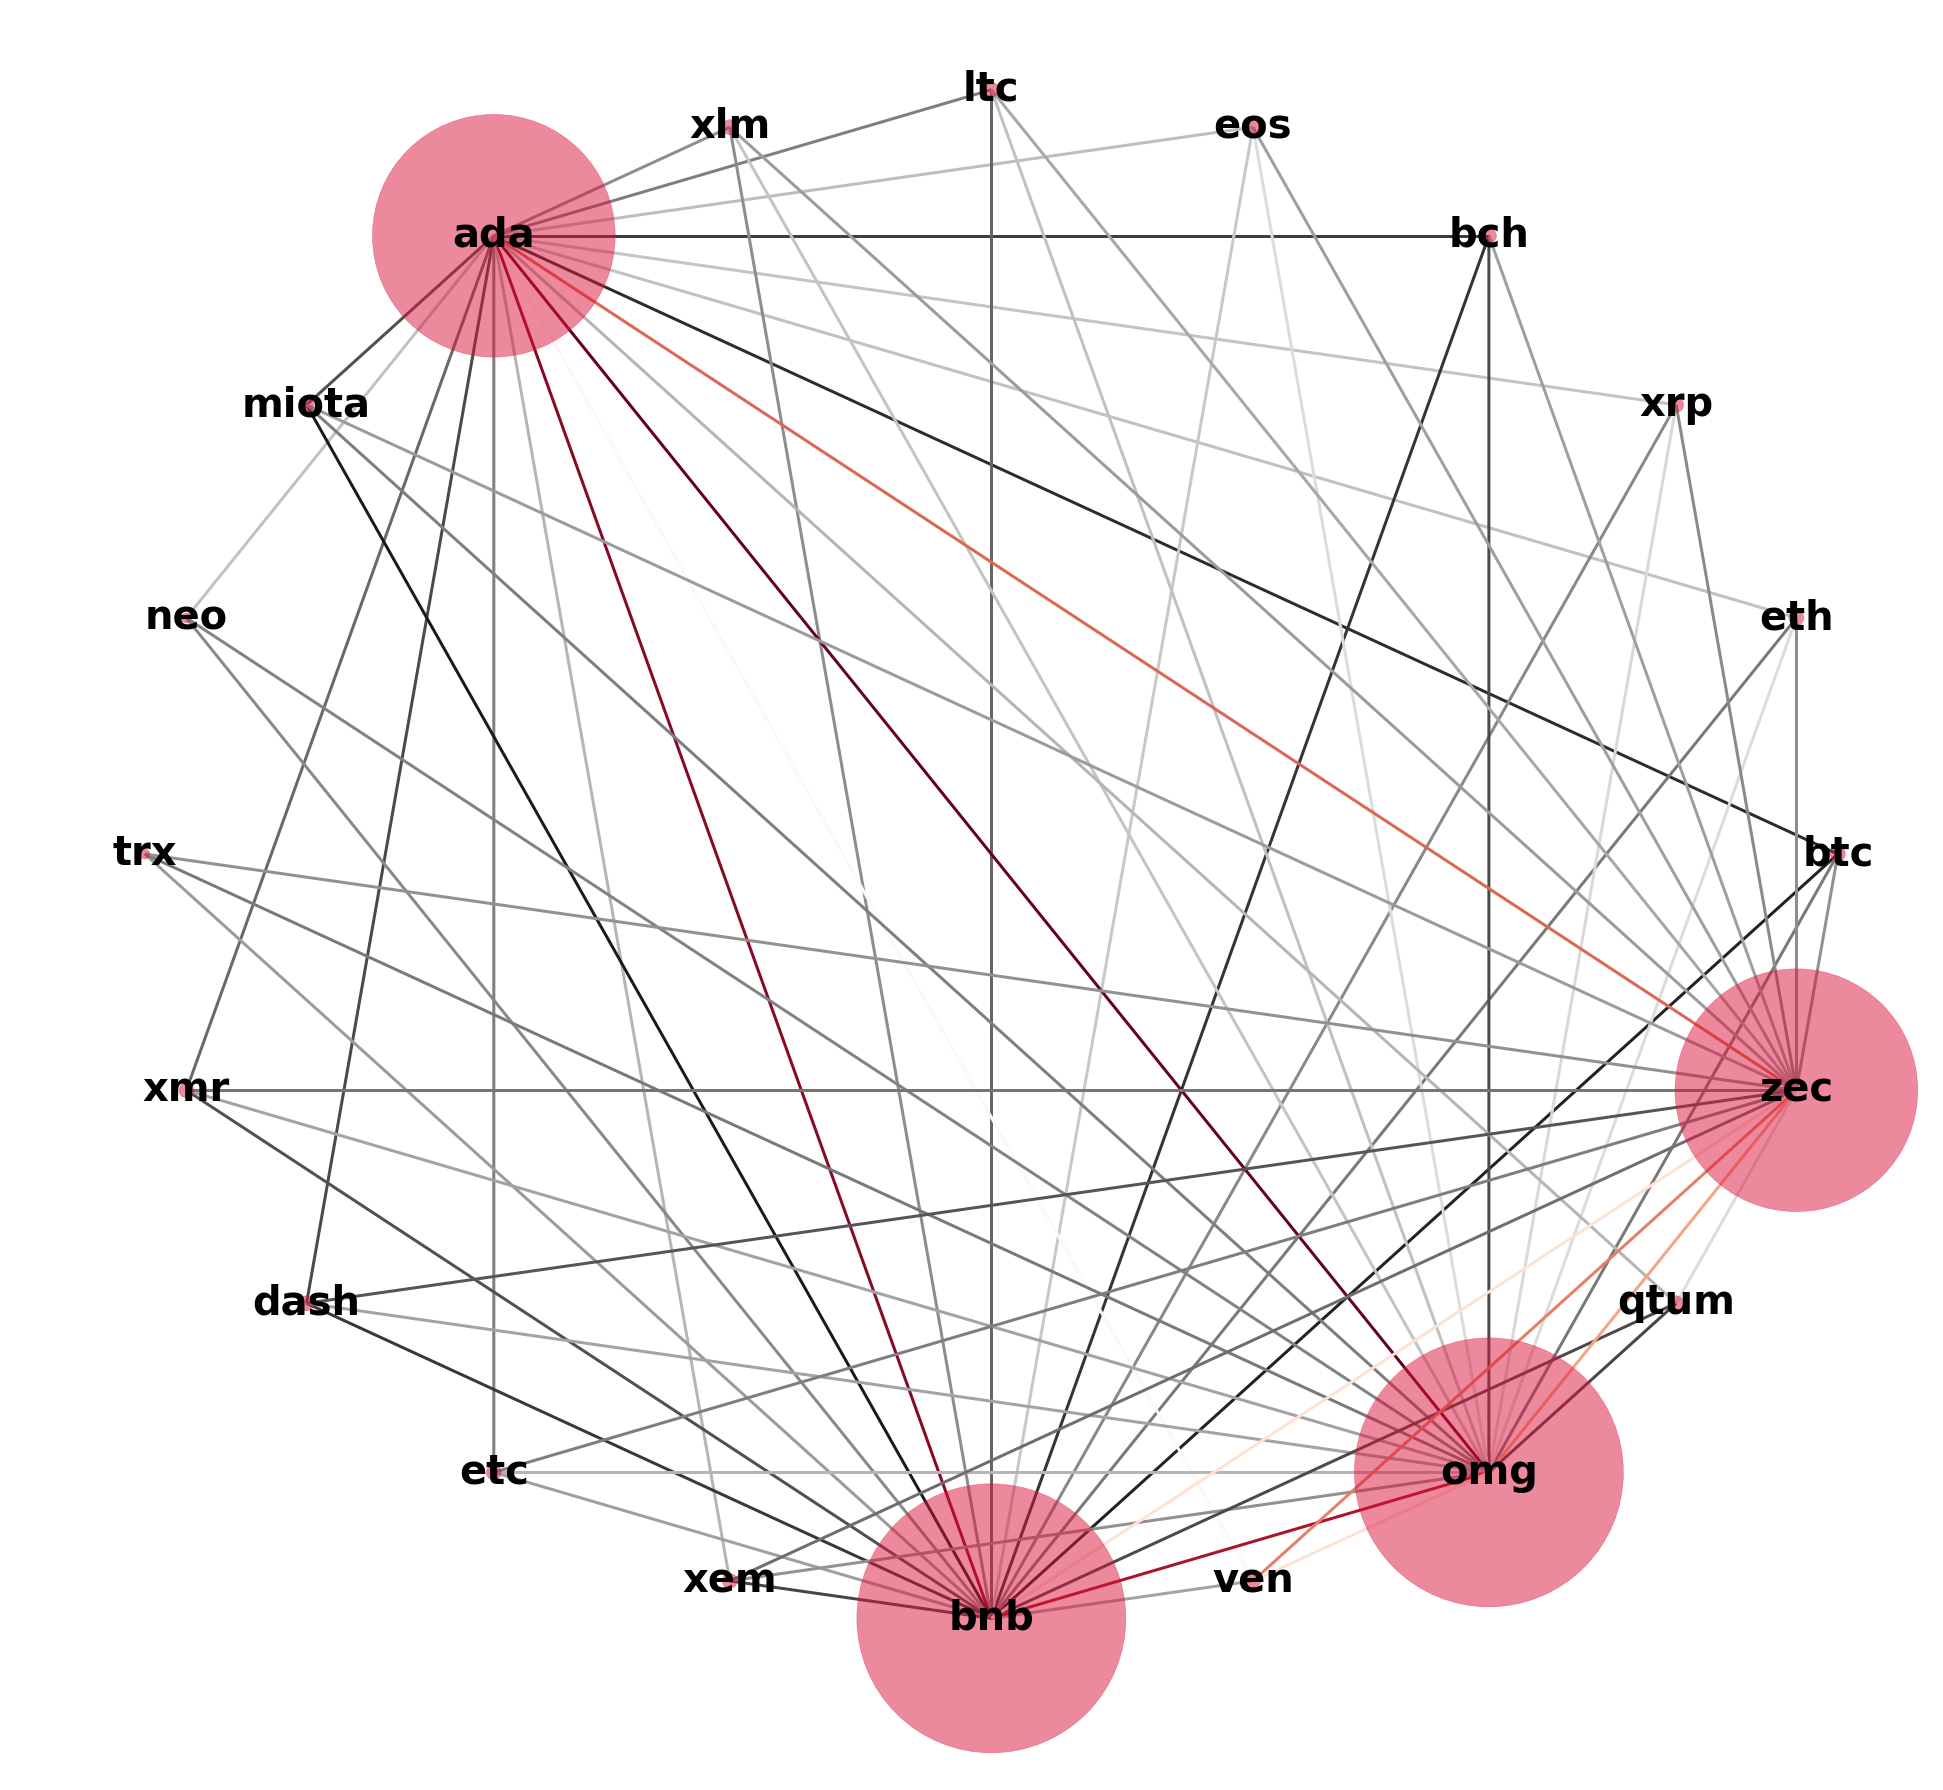

In [1713]:
# Visualization

# Remove all NaNs
# symbsToExclude = df[df.isnull().all()].index.get_values()
# df.drop(symbsToExclude, axis=0, inplace=True)
# df.drop(symbsToExclude, axis=1, inplace=True)

# Get all labels
names = topXCorr.index.get_values()

cor_matrix = np.asmatrix(topXCorr)
cor_matrix = cor_matrix.astype(np.float64)

# Creates graph using the data of the correlation matrix
G = nx.from_numpy_matrix(cor_matrix)

# # Relabels the nodes to match the  stocks names
G = nx.relabel_nodes(G, lambda x: names[x])

# Shows the edges with their corresponding weights
# G.edges(data=True)

# Function to create and display networks from the correlatin matrix
def create_corr_network_1(G, corr_direction):
    
    # edge colors based on weight direction plt.cm.OrRd
    cms = {'positive': plt.cm.RdGy_r, 'negative': plt.cm.PuRd, 'non': plt.cm.PRGn}
    edge_colour = cms.get(corr_direction)
    
    # Remove selfloop edges as they are counted twice for node degrees
    G.remove_edges_from(G.selfloop_edges())
    
    # Remove isolates - nodes with degree 0
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # creates a list for edges and for the weights
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    # normalize weights
    min_w = np.amin(weights)
    n_weights = (weights - min_w) * 100
    
    # increases the value of weights, so that they are more visible in the graph
    vis_weights = tuple([abs(x) for x in n_weights])
    
    #Figure size
    plt.figure(figsize=(30,30))
    
    # Calculates the degree of each node
    d = nx.degree(G)
    # creates list of nodes and a list their degrees that will be used later for their sizes
    nodelist, node_sizes = zip(*d)
    
    #positions
    positions = nx.circular_layout(G)
    print('Generating image for # number of nodes:', len(positions))

    nx.draw_networkx_nodes(G,
                           positions,
                           alpha=0.5,
                           node_color='#DC143C',
                           node_size=tuple([30+x**3.8 for x in node_sizes])) # 
    
    nx.draw_networkx_labels(G, positions, font_size=40, font_family='sans-serif', font_weight='bold')

    nx.draw_networkx_edges(G, positions, edge_list=edges, style='solid',
                      ###adds width=weights and edge_color = weights 
                      ###so that edges are based on the weight parameter 
                      ###edge_cmap is for the color scale based on the weight
                      ### edge_vmin and edge_vmax assign the min and max weights for the width
                      edge_color = vis_weights, edge_cmap = edge_colour, 
                      width = 3
                      )
    # width = vis_weights,
    # edge_vmin = min(vis_weights), edge_vmax=max(vis_weights)
    
#     nx.draw_networkx_edge_labels(G, 
#                                  positions, 
#                                  font_size=20,
#                                  edge_labels=nx.get_edge_attributes(G, 'weight'))
    
    # displays the graph without axis
    plt.axis('off')
    # saves image
    plt.savefig(corr_direction + ".png", format="PNG")
    plt.show()

# create_corr_network_1(G)

def create_corr_network(G, corr_direction):
    
    H = G.copy()
    
    for c1, c2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] < 0.90:
                H.remove_edge(c1, c2)
        elif corr_direction == "negative":
            if weight["weight"] > -0.7:
                H.remove_edge(c1, c2)
        elif corr_direction == "non":
            if (weight["weight"] <= -0.02) or (weight["weight"] >= 0.02):
                H.remove_edge(c1, c2)
        else:
            raise Exception('Invalid argument value corr_direction:', corr_direction)
    
    create_corr_network_1(H, corr_direction)

def create_corr_network_top20(G):
    
    H = G.copy()
    
    for c1, c2, weight in G.edges(data=True):
        if np.isnan(weight["weight"]):
            H.remove_edge(c1, c2)
    
    create_corr_network_1(H, 'positive')

create_corr_network_top20(G)
#create_corr_network(G, 'positive')
#create_corr_network(G, 'negative')
#create_corr_network(G, 'non')

